# Image Classification with TensorFlow

In [11]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.1.0
Eager execution: True


In [4]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [5]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

<img src="convolutional-neural-network-images/SIGNS.png" style="width:800px;height:300px;">

y = 2


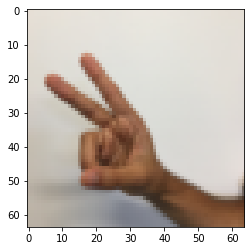

In [6]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [7]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [10]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [56]:
class Model(object):
    def __init__(self, X, Y):
        tf.random.set_seed(1)
        xavier_initializer = tf.initializers.GlorotUniform()
        self.W1 = tf.Variable(xavier_initializer(shape=[4, 4, 3, 8]), dtype='float32')
        self.W2 = tf.Variable(xavier_initializer(shape=[2, 2, 8, 16]), dtype='float32')
             
    def __call__(self, X):
        # CONV2D: stride of 1, padding 'SAME'
        self.Z1 = tf.nn.conv2d(X, self.W1, strides = [1,1,1,1], padding = 'SAME')
        print("Z1: " + str(self.Z1.shape))
        
        # RELU
        self.A1 = tf.nn.relu(self.Z1)
        print("A1: " + str(self.A1.shape))
        
        # MAXPOOL: window 8x8, stride 8, padding 'SAME'
        self.P1 = tf.nn.max_pool(self.A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
        print("P1: " + str(self.P1.shape))
        
        # CONV2D: filters W2, stride 1, padding 'SAME'
        self.Z2 = tf.nn.conv2d(self.P1, self.W2, strides = [1,1,1,1], padding = 'SAME')
        print("Z2: " + str(self.Z2.shape))
        
        # RELU
        self.A2 = tf.nn.relu(self.Z2)
        print("A2: " + str(self.A2.shape))
        
        # MAXPOOL: window 4x4, stride 4, padding 'SAME'
        self.P2 = tf.nn.max_pool(self.A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
        print("P2: " + str(self.P2.shape))
        
        # FLATTEN
        self.F = tf.keras.layers.Flatten()(self.P2)
        print("F: " + str(self.F.shape))
        
        # FULLY-CONNECTED without non-linear activation function (not not call softmax).
        # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
        self.Z3 = tf.keras.layers.Dense(self.F,activation=None)
        #self.Z3 = tf.contrib.layers.fully_connected(self.F, 6, activation_fn=None)
        
        return self.Z3

In [57]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 6)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost

In [58]:
def train(model, inputs, outputs):
    """
    Trains the model
    
    Args:
    model -- Model object defined above
    inputs -- X_train input of training data
    outputs -- Y_train output of training data
    
    Returns:
    None
    """
    
    with tf.GradientTape() as t:
        current_loss = compute_cost(model(inputs), outputs)
        grads = t.gradient(current_loss, [model.W1, model.W2])
        optimizer.apply_gradients(zip(grads, [model.W1, model.W2]))
        costs.append(current_loss)
    if epoch % 10 == 0:
        print ("Cost after epoch %i: %f" % (epoch, current_loss))

In [65]:
X_train = X_train.astype('float32')
print("X_train: " + str(X_train.shape))
print(tf.unpack(X_train))

learning_rate = 0.01
costs = []
num_epochs = 100

model = Model(X_train, Y_train)
optimizer = tf.optimizers.Adam(learning_rate)

for epoch in range(num_epochs):
    train(model, X_train, Y_train)
# plot the cost
#plt.plot(np.squeeze(costs))
#plt.ylabel('cost')
#plt.xlabel('iterations (per fives)')
#plt.title("Learning rate =" + str(learning_rate))
#plt.show()

X_train: (1080, 64, 64, 3)


AttributeError: module 'tensorflow' has no attribute 'unpack'